In [13]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tools.feature_selection as fs
import tools.preprocessing as ps
import tools.evaluations as ev

## 读取数据

In [2]:
df_train = pd.read_csv('../project/home-credit-default-risk/application_train.csv')

## 数据处理

In [3]:
cate_vars = []
cont_vars = []
for col in df_train.columns:
    if col not in ['SK_ID_CURR','TARGET']:
        if df_train[col].dtype in ['float64','int64'] and df_train[col].nunique() > 3:
            cont_vars.append(col)
        else:
            cate_vars.append(col)

In [4]:
# 编码类别变量
df_train = ps.cate_enc(df_train, cate_vars)

## 特征筛选

In [49]:
df_train_woe = df_train.fillna(-1)
df_train_woe['target'] = df_train_woe['TARGET']
df_train_woe.drop('TARGET',axis=1,inplace=True)

In [50]:
df_iv = fs.cal_iv(df_train_woe,cate_vars,cont_vars,'target')

--------process discrete variable:NAME_CONTRACT_TYPE--------


C:\Users\John Zheng\Anaconda3\lib\site-packages\woe\feature_process.py:414: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[var] = cpvar


-----------process discrete variable:CODE_GENDER------------
-----------process discrete variable:FLAG_OWN_CAR-----------
---------process discrete variable:FLAG_OWN_REALTY----------
---------process discrete variable:NAME_TYPE_SUITE----------
---------process discrete variable:NAME_INCOME_TYPE---------
-------process discrete variable:NAME_EDUCATION_TYPE--------
--------process discrete variable:NAME_FAMILY_STATUS--------
--------process discrete variable:NAME_HOUSING_TYPE---------
------------process discrete variable:FLAG_MOBIL------------
----------process discrete variable:FLAG_EMP_PHONE----------
---------process discrete variable:FLAG_WORK_PHONE----------
---------process discrete variable:FLAG_CONT_MOBILE---------
------------process discrete variable:FLAG_PHONE------------
------------process discrete variable:FLAG_EMAIL------------
---------process discrete variable:OCCUPATION_TYPE----------
-------process discrete variable:REGION_RATING_CLIENT-------
---process discrete vari

In [52]:
df_iv.to_excel('./features/df_train_iv.xlsx',index=False)

C:\Users\John Zheng\Anaconda3\lib\site-packages\pandas\compat\_optional.py:106: UserWarning: Pandas requires version '0.9.8' or newer of 'xlsxwriter' (version '0.9.6' currently installed).
  warnings.warn(msg, UserWarning)


In [5]:
df_iv = pd.read_excel('./features/df_train_iv.xlsx')
iv_features_train = df_iv[df_iv['iv']>0.02]['var_name'].values

## 建模

In [6]:
# 根据选择的模型决定用不用填补缺失值
df_train.fillna(-1,inplace=True)

In [7]:
# 将TARGET编码为分类变量
df_train['TARGET'] = df_train['TARGET'].astype('category')

In [8]:
# 分割数据集
X_train, X_test, y_train, y_test = ps.split_data(df_train,iv_features_train,'TARGET')

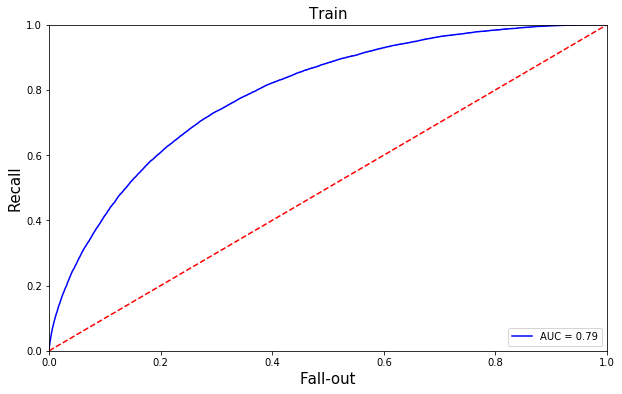

AUC:  0.7901637840475843
KS:  0.43512513151916704


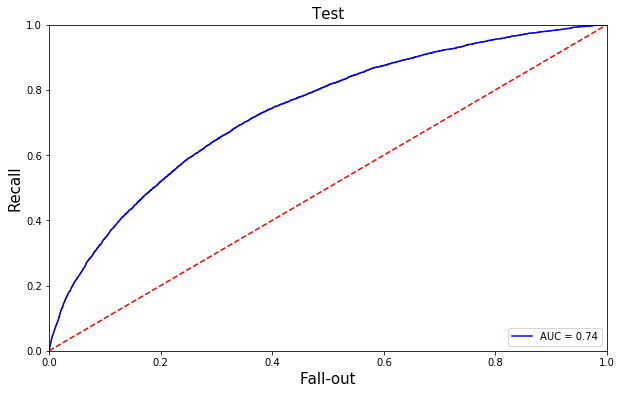

AUC:  0.7352715204010426
KS:  0.3509816144763585


In [11]:
from sklearn.ensemble import RandomForestClassifier

# 训练模型
model = RandomForestClassifier(max_depth=9,n_estimators=200)
model.fit(X_train, y_train)

# 输出概率
y_hat = model.predict_proba(X_train)[:,1]
y_pred = model.predict_proba(X_test)[:,1]

# 模型评价
ev.plot_ROC(y_train, y_hat, 'Train')
ev.plot_ROC(y_test, y_pred, 'Test')